# Session 9: Synthetic Data Generation and RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow, and use it to evaluate and iterate on a RAG pipeline with LangSmith!

**Learning Objectives:**
- Understand Ragas' knowledge graph-based synthetic data generation workflow
- Generate synthetic test sets with different query synthesizer types
- Load synthetic data into LangSmith for evaluation
- Evaluate a RAG chain using LangSmith evaluators
- Iterate on RAG pipeline parameters and measure the impact

## Table of Contents:

- **Breakout Room #1:** Synthetic Data Generation with Ragas
  - Task 1: Dependencies and API Keys
  - Task 2: Data Preparation and Knowledge Graph Construction
  - Task 3: Generating Synthetic Test Data
  - Question #1 & Question #2
  - 🏗️ Activity #1: Custom Query Distribution

- **Breakout Room #2:** RAG Evaluation with LangSmith
  - Task 4: LangSmith Dataset Setup
  - Task 5: Building a Basic RAG Chain
  - Task 6: Evaluating with LangSmith
  - Task 7: Modifying the Pipeline and Re-Evaluating
  - Question #3 & Question #4
  - 🏗️ Activity #2: Analyze Evaluation Results

---
# 🤝 Breakout Room #1
## Synthetic Data Generation with Ragas

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

## Dependencies and API Keys:

### NLTK Import

To prevent errors that may occur based on OS - we'll import NLTK and download the needed packages to ensure correct handling of data.

In [1]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/stevegoodman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/stevegoodman/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [18]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

We'll also want to set a project name to make things easier for ourselves.

In [19]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [4]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data using two complementary guides — a Health & Wellness Guide covering exercise, nutrition, sleep, and stress management, and a Mental Health & Psychology Handbook covering mental health conditions, therapeutic approaches, resilience, and daily mental health practices. The topical overlap between documents helps RAGAS build rich cross-document relationships in the knowledge graph.

Next, let's load our data into a familiar LangChain format using the `TextLoader`.

In [5]:
from langchain_community.document_loaders import DirectoryLoader, TextLoader

loader = DirectoryLoader("data/", glob="*.txt", loader_cls=TextLoader)
docs = loader.load()
print(f"Loaded {len(docs)} documents: {[d.metadata['source'] for d in docs]}")

Loaded 2 documents: ['data/MentalHealthGuide.txt', 'data/HealthWellnessGuide.txt']


### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Unrolled SDG

In [6]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

Next, we're going to instantiate our Knowledge Graph.

This graph will contain N number of nodes that have M number of relationships. These nodes and relationships (AKA "edges") will define our knowledge graph and be used later to construct relevant questions and responses.

In [7]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

The first step we're going to take is to simply insert each of our full documents into the graph. This will provide a base that we can apply transformations to.

In [8]:
from ragas.testset.graph import Node, NodeType

for doc in docs:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 2, relationships: 0)

Now, we'll apply the *default* transformations to our knowledge graph. This will take the nodes currently on the graph and transform them based on a set of [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms).

These default transformations are dependent on the corpus length, in our case:

- Producing Summaries -> produces summaries of the documents
- Extracting Headlines -> finding the overall headline for the document
- Theme Extractor -> extracts broad themes about the documents

It then uses cosine-similarity and heuristics between the embeddings of the above transformations to construct relationships between the nodes.

In [9]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/7 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/16 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

KnowledgeGraph(nodes: 9, relationships: 14)

We can save and load our knowledge graphs as follows.

In [10]:
kg.save("usecase_data_kg.json")
usecase_data_kg = KnowledgeGraph.load("usecase_data_kg.json")
usecase_data_kg

KnowledgeGraph(nodes: 9, relationships: 14)

Using our knowledge graph, we can construct a "test set generator" - which will allow us to create queries.

In [11]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=usecase_data_kg)

However, we'd like to be able to define the kinds of queries we're generating - which is made simple by Ragas having pre-created a number of different "QuerySynthesizer"s.

Each of these Synthetsizers is going to tackle a separate kind of query which will be generated from a scenario and a persona.

In essence, Ragas will use an LLM to generate a persona of someone who would interact with the data - and then use a scenario to construct a question from that data and persona.

In [22]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

## ❓ Question #1:

What are the three types of query synthesizers doing? Describe each one in simple terms.

##### Answer:
SingleHop means being able to pose and answer the question within a single chunk or data source
Multiple Hop are questions that are spread over multiple data sources
Specific v Abstract - Specific quests are more like facts, whereas abstract queries answer more general questions that requires some element of opinion forming or reasoning over the data sources.



Finally, we can use our `TestSetGenerator` to generate our testset!

In [23]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,How does the United States impact mental healt...,[The Mental Health and Psychology Handbook A P...,The provided context does not include informat...,single_hop_specifc_query_synthesizer
1,What is COGNITIV BEHAVIORAL THERAPY?,[PART 2: THERAPEUTIC APPROACHES Chapter 4: Cog...,Cognitive Behavioral Therapy is one of the mos...,single_hop_specifc_query_synthesizer
2,How does dementia relate to mental health?,[Write letters to or from your future self Jou...,The provided context does not include specific...,single_hop_specifc_query_synthesizer
3,How can managing digital mental health help wi...,[social interactions How to set and maintain b...,Managing digital mental health involves strate...,single_hop_specifc_query_synthesizer
4,What are some key tips for effective meal plan...,[PART 2: NUTRITION AND DIET Chapter 4: Fundame...,Effective meal planning for wellness involves ...,single_hop_specifc_query_synthesizer
5,how stress management techniques like mindfuln...,[<1-hop>\n\nPART 2: NUTRITION AND DIET Chapter...,The context explains that mindfulness and medi...,multi_hop_abstract_query_synthesizer
6,Considering the importance of self-awareness a...,[<1-hop>\n\nsocial interactions How to set and...,Individuals can develop balanced health routin...,multi_hop_abstract_query_synthesizer
7,How can implementing daily wellness practices ...,[<1-hop>\n\nsocial interactions How to set and...,Implementing daily wellness practices such as ...,multi_hop_abstract_query_synthesizer
8,How can setting boundaries and practicing digi...,[<1-hop>\n\nsocial interactions How to set and...,"Setting and maintaining boundaries, as outline...",multi_hop_specific_query_synthesizer
9,How can managing digital mental health strateg...,[<1-hop>\n\nsocial interactions How to set and...,Managing digital mental health strategies from...,multi_hop_specific_query_synthesizer


### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [14]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/8 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/16 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [15]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,What are the recommended exercises and strateg...,[The Personal Wellness Guide A Comprehensive R...,The provided context does not include specific...,single_hop_specifc_query_synthesizer
1,What does Stage 2 of sleep involve in the slee...,[PART 3: SLEEP AND RECOVERY Chapter 7: The Sci...,Stage 2 involves a drop in body temperature an...,single_hop_specifc_query_synthesizer
2,What information does Chapter 18 cover regardi...,[PART 5: BUILDING HEALTHY HABITS Chapter 13: T...,Chapter 18 discusses strategies to boost immun...,single_hop_specifc_query_synthesizer
3,How does the World Health Organization define ...,[The Mental Health and Psychology Handbook A P...,"According to the World Health Organization, me...",single_hop_specifc_query_synthesizer
4,how can exercise for common problems like lowe...,[<1-hop>\n\nThe Personal Wellness Guide A Comp...,The wellness guide explains that gentle exerci...,multi_hop_abstract_query_synthesizer
5,How can incorporating mindfulness and social c...,[<1-hop>\n\nhour before bed - No caffeine afte...,Incorporating mindfulness and social connectio...,multi_hop_abstract_query_synthesizer
6,How can improving face-to-face interactions an...,[<1-hop>\n\nhour before bed - No caffeine afte...,Improving face-to-face interactions by engagin...,multi_hop_abstract_query_synthesizer
7,How can I improve my emotional intelligence an...,[<1-hop>\n\nhour before bed - No caffeine afte...,To improve emotional intelligence and manage c...,multi_hop_abstract_query_synthesizer
8,how chapter 7 and 17 connect about sleep and h...,[<1-hop>\n\nPART 3: SLEEP AND RECOVERY Chapter...,"chapter 7 talks about sleep and recovery, expl...",multi_hop_specific_query_synthesizer
9,H0w c4n I bUild a he4lthy m0rn1ng r0utine (cha...,[<1-hop>\n\nPART 3: SLEEP AND RECOVERY Chapter...,To build a healthy morning routine that improv...,multi_hop_specific_query_synthesizer


## ❓ Question #2:

Ragas offers both an "unrolled" (manual) approach and an "abstracted" (automatic) approach to synthetic data generation. What are the trade-offs between these two approaches? When would you choose one over the other?

##### Answer:
Automated versions are quick and easy ways of generating evaluating datasets to boostrap projects quickly, and get into the flow of a good test-evaluate loop. However, there is little control over how the underlying knolwedge is represented.

The manual approach is for finer grained control over knowledge representation and generating relationships between entities and data sources. It might be the case that the knowledge can be augmented by a subject matter expert that can map out  domain-specific relationships based on their tacit knolwedge and experience, something that may not always be explicitly captured documentation, or captured incorrectly or abiguously for some reason.

---
## 🏗️ Activity #1: Custom Query Distribution

Modify the `query_distribution` to experiment with different ratios of query types.

### Requirements:
1. Create a custom query distribution with different weights than the default
2. Generate a new test set using your custom distribution
3. Compare the types of questions generated with the default distribution
4. Explain why you chose the weights you did

In [ ]:
### YOUR CODE HERE ###

# Define a custom query distribution with different weights
# Generate a new test set and compare with the default

# Singlehop queries are easiest to solve, it will be comparitively easy to get a good overall score
# with little optimisation required the dataset is composed of a high proportion of these. 
# its prudent to try to solve and optimise for the harder questions. 
# The dataset size, n=10 size is too small a sampe size- we need at least a handful of queries of each type to
# be more sure that our assement is a little more robust 
# n=25 seems about the upper limit I can get to without my llm request erroring-out too much.

custom_query_distribution = [
    (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.10),
    (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.45),
    (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.45),
]


baseline = generator.generate(testset_size=25, query_distribution=query_distribution)





Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/28 [00:00<?, ?it/s]

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x111360880> is already entered
Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x111360880> is already entered
Task was destroyed but it is pending!
task: <Task pending name='Task-387' coro=<_async_in_context.<locals>.r

In [28]:
custom_testset = generator.generate(testset_size=25, query_distribution= custom_query_distribution)


Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Task was destroyed but it is pending!
task: <Task pending name='Task-453' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/stevegoodman/dev/AIE9/09_Synthetic_Data_Generation_and_LangSmith/.venv/lib/python3.13/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-454' coro=<Kernel.shell_main() running at /Users/stevegoodman/dev/AIE9/09_Synthetic_Data_Generation_and_LangSmith/.venv/lib/python3.13/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/stevegoodman/dev/AIE9/09_Synthetic_Data_Generation_and_LangSmith/.venv/lib/python3.13/site-packages/zmq/eventloop/zmqstream.py:563]>
/Users/stevegoodman/dev/AIE9/09_Synthetic_Data_Generation_and_LangSmith/.venv/lib/python3.13/site-packages/ragas/testset/synthesizers/multi_hop/base.py:115: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  all_possible_samples.append(
Task was destroyed but it is pending!
task: <Task 

Generating Samples:   0%|          | 0/27 [00:00<?, ?it/s]

We'll need to provide our LangSmith API key, and set tracing to "true".

In [30]:
baseline.to_pandas()


,user_input,reference_contexts,reference,synthesizer_name
0,Whaat is the role of the Wrold Healt Organizat...,[The Mental Health and Psychology Handbook A P...,"According to the context, the World Health Org...",single_hop_specifc_query_synthesizer
1,Wha is the role of the World Health Organizato...,[The Mental Health and Psychology Handbook A P...,"According to the context, the World Health Org...",single_hop_specifc_query_synthesizer
2,What is Dialectical Behavior Therapy and how d...,[PART 2: THERAPEUTIC APPROACHES Chapter 4: Cog...,Dialectical Behavior Therapy (DBT) is a therap...,single_hop_specifc_query_synthesizer
3,What is Mindfulness-Based Cognitive Therapy an...,[PART 2: THERAPEUTIC APPROACHES Chapter 4: Cog...,Mindfulness-Based Cognitive Therapy (MBCT) com...,single_hop_specifc_query_synthesizer
4,How does exercise contribute to mental health ...,[Write letters to or from your future self Jou...,Exercise affects the brain in multiple benefic...,single_hop_specifc_query_synthesizer
5,What is CBT-I and how does it relate to mental...,[Write letters to or from your future self Jou...,CBT-I is the recommended first-line treatment ...,single_hop_specifc_query_synthesizer
6,How do social interactions influence mental he...,[social interactions How to set and maintain b...,Social interactions are important for mental h...,single_hop_specifc_query_synthesizer
7,How can I effectively manage digital mental he...,[social interactions How to set and maintain b...,Managing Digital Mental Health involves settin...,single_hop_specifc_query_synthesizer
8,What information can I find in Chapter 7 regar...,[PART 2: NUTRITION AND DIET Chapter 4: Fundame...,"Chapter 7 discusses the science of sleep, emph...",single_hop_specifc_query_synthesizer
9,How does stress affect your body and mind?,[PART 2: NUTRITION AND DIET Chapter 4: Fundame...,Stress is the body's response to any demand or...,single_hop_specifc_query_synthesizer


In [75]:
print("baseline dataset distribution")
baseline.to_pandas().groupby('synthesizer_name')['user_input'].count()

baseline dataset distribution


synthesizer_name
multi_hop_abstract_query_synthesizer     7
multi_hop_specific_query_synthesizer     7
single_hop_specifc_query_synthesizer    14
Name: user_input, dtype: int64

In [31]:
custom_testset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,How does mental health impact physical health ...,[The Mental Health and Psychology Handbook A P...,Research demonstrates a powerful connection be...,single_hop_specifc_query_synthesizer
1,"What is Mindfulness-Based Stress Reduction, an...",[PART 2: THERAPEUTIC APPROACHES Chapter 4: Cog...,Mindfulness-Based Stress Reduction (MBSR) is a...,single_hop_specifc_query_synthesizer
2,How does serotonin relate to mental health and...,[Write letters to or from your future self Jou...,Serotonin is mentioned in the context of exerc...,single_hop_specifc_query_synthesizer
3,How does trauma affect mental health and how c...,[<1-hop>\n\nThe Mental Health and Psychology H...,Trauma can negatively impact mental health by ...,multi_hop_abstract_query_synthesizer
4,How can developing emotional intelligence thro...,[<1-hop>\n\nPART 2: THERAPEUTIC APPROACHES Cha...,Developing emotional intelligence involves pra...,multi_hop_abstract_query_synthesizer
5,How can developing emotional intelligence thro...,[<1-hop>\n\nPART 2: THERAPEUTIC APPROACHES Cha...,Developing emotional intelligence involves rec...,multi_hop_abstract_query_synthesizer
6,How can Cognitive Behavioral Therapy (CBT) tec...,[<1-hop>\n\nThe Mental Health and Psychology H...,"Cognitive Behavioral Therapy (CBT) techniques,...",multi_hop_abstract_query_synthesizer
7,"H0w c4n d4ily mental health pract1ces, l1ke jo...",[<1-hop>\n\nPART 2: THERAPEUTIC APPROACHES Cha...,D4ily mental health pract1ces such as journali...,multi_hop_abstract_query_synthesizer
8,How does trauma affect mental health and how c...,[<1-hop>\n\nThe Mental Health and Psychology H...,Trauma can significantly impact mental health ...,multi_hop_abstract_query_synthesizer
9,How does understanding trauma and building res...,[<1-hop>\n\nThe Mental Health and Psychology H...,The handbook explains that trauma can signific...,multi_hop_abstract_query_synthesizer


In [47]:
print("custom dataset question distribution")
custom_testset.to_pandas().groupby('synthesizer_name')['user_input'].count()





custom dataset question distribution


synthesizer_name
multi_hop_abstract_query_synthesizer    12
multi_hop_specific_query_synthesizer    12
single_hop_specifc_query_synthesizer     3
Name: user_input, dtype: int64

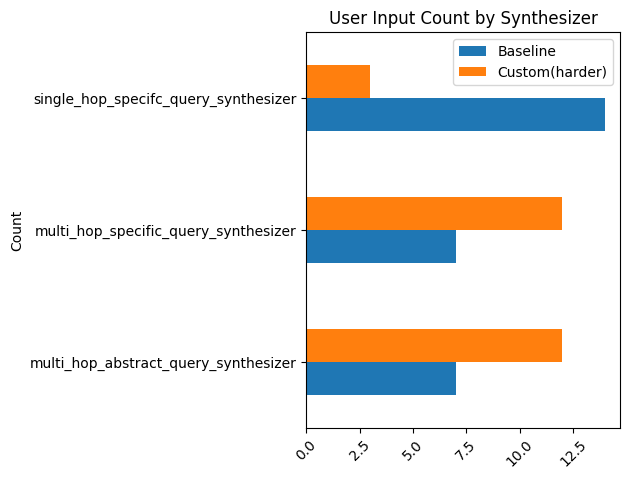

In [76]:

import pandas as pd
import matplotlib.pyplot as plt

# Compute grouped counts
baseline_counts = (
    baseline.to_pandas()
    .groupby('synthesizer_name')['user_input']
    .count()
)

custom_counts = (
    custom_testset.to_pandas()
    .groupby('synthesizer_name')['user_input']
    .count()
)

# Combine into one DataFrame
combined = pd.concat(
    [baseline_counts, custom_counts],
    axis=1,
    keys=['Baseline', 'Custom(harder)']
)

# Plot grouped bar chart
combined.plot(kind='barh')
plt.ylabel('Count')
plt.title('User Input Count by Synthesizer')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [60]:
print(custom_testset.to_pandas().query(" synthesizer_name=='single_hop_specifc_query_synthesizer'")['user_input'])


0    How does mental health impact physical health and vice versa according to recent research?
1        What is Mindfulness-Based Stress Reduction, and how does it aim to improve well-being?
2                                    How does serotonin relate to mental health and well-being?
Name: user_input, dtype: str


In [58]:
pd.set_option('display.max_colwidth', 120)
print(custom_testset.to_pandas().query(" synthesizer_name=='multi_hop_abstract_query_synthesizer'")['user_input'])



3                                                   How does trauma affect mental health and how can buildng resilience help?
4     How can developing emotional intelligence through strategies like emotion journaling and mindfulness support buildin...
5     How can developing emotional intelligence through strategies such as emotion journaling, mindfulness, active listeni...
6     How can Cognitive Behavioral Therapy (CBT) techniques, such as thought records and behavioral activation, be integra...
7     H0w c4n d4ily mental health pract1ces, l1ke journaling benefits, help w1th em0tional pr0cessing and stress r3duction...
8     How does trauma affect mental health and how can building resilience help manage its psychological effects, especial...
9                How does understanding trauma and building resilience relate to mental health, as discussed in the handbook?
10    How can understanding trauma and building resilience, as discussed in mental health resources, help individuals 

## Comments
Single hop questions tend to be short and direct - Arguably some of these could be handled with retrieval only or conventional search engines,  without the need to build a RAG system or use an LLM.

The abstract, multiple hop questions ask longer, multi-faceted questions that are more demanding and often span either multiple documents or multiple chapters within a document that require the synthesis step to piece together a complete answer from semantic chunks. This is where reasoning and generation shines (or fails).


---
# 🤝 Breakout Room #2
## RAG Evaluation with LangSmith

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [ ]:
from langsmith import Client
import uuid

client = Client()

dataset_name = f"Use Case Synthetic Data - AIE9 - {uuid.uuid4()}"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Synthetic Data for Use Cases"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [22]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## Basic RAG Chain

Time for some RAG!


In [23]:
rag_documents = docs

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [24]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [25]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [26]:
from langchain_qdrant import QdrantVectorStore

vectorstore = QdrantVectorStore.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="use_case_rag"
)

In [27]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

To get the "A" in RAG, we'll provide a prompt.

In [29]:
from langchain_core.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

As is usual: We'll be using `gpt-4.1-mini` for our RAG!

In [30]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini")

Finally, we can set-up our RAG LCEL chain!

In [33]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain_core.output_parsers import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [34]:
rag_chain.invoke({"question" : "What are some recommended exercises for lower back pain?"})

'Recommended exercises for lower back pain include:\n\n- Cat-Cow Stretch: Start on hands and knees, alternate between arching your back up (cat) and letting it sag down (cow). Do 10-15 repetitions.\n- Bird Dog: From hands and knees, extend opposite arm and leg while keeping your core engaged. Hold for 5 seconds, then switch sides. Do 10 repetitions per side.\n- Partial Crunches: Lie on your back with knees bent, cross arms over chest, tighten stomach muscles and raise shoulders off floor. Hold briefly, then lower. Do 8-12 repetitions.\n- Knee-to-Chest Stretch: Lie on your back, pull one knee toward your chest while keeping the other foot flat. Hold for 15-30 seconds, then switch legs.\n- Pelvic Tilts: Lie on your back with knees bent, flatten your back against the floor by tightening abs and tilting pelvis up slightly. Hold for 10 seconds, repeat 8-12 times.'

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4.1 as our evaluation LLM for our base Evaluators.

In [ ]:
eval_llm = ChatOpenAI(model="gpt-4.1")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [40]:
from openevals.llm import create_llm_as_judge
from langsmith.evaluation import evaluate

# 1. QA Correctness (replaces LangChainStringEvaluator("qa"))
qa_evaluator = create_llm_as_judge(
    prompt="You are evaluating a QA system. Given the input, assess whether the prediction is correct.\n\nInput: {inputs}\nPrediction: {outputs}\nReference answer: {reference_outputs}\n\nIs the prediction correct? Return 1 if correct, 0 if incorrect.",
    feedback_key="qa",
    model="openai:gpt-4o" ,  # pass your LangChain chat model directly
)

# 2. Labeled Helpfulness (replaces LangChainStringEvaluator("labeled_criteria"))
labeled_helpfulness_evaluator = create_llm_as_judge(
    prompt=(
        "You are assessing a submission based on the following criterion:\n\n"
        "helpfulness: Is this submission helpful to the user, "
        "taking into account the correct reference answer?\n\n"
        "Input: {inputs}\n"
        "Submission: {outputs}\n"
        "Reference answer: {reference_outputs}\n\n"
        "Does the submission meet the criterion? Return 1 if yes, 0 if no."
    ),
    feedback_key="helpfulness",
    model="openai:gpt-4o" ,
)

# 3. Dopeness (replaces LangChainStringEvaluator("criteria"))
dopeness_evaluator = create_llm_as_judge(
    prompt=(
        "You are assessing a submission based on the following criterion:\n\n"
        "dopeness: Is this response dope, lit, cool, or is it just a generic response?\n\n"
        "Input: {inputs}\n"
        "Submission: {outputs}\n\n"
        "Does the submission meet the criterion? Return 1 if yes, 0 if no."
    ),
    feedback_key="dopeness",
    model="openai:gpt-4o" ,
)

> **Describe what each evaluator is evaluating:**
>
> - `qa_evaluator`:
> - `labeled_helpfulness_evaluator`:
> - `dopeness_evaluator`:

## LangSmith Evaluation

In [41]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dopeness_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)

View the evaluation results for experiment: 'timely-touch-90' at:
https://smith.langchain.com/o/340cd80b-3296-5752-9a9e-58582118073a/datasets/79646c5e-82fe-4bbc-85e9-567b67cd20a9/compare?selectedSessions=e593260f-0449-4d53-8152-58514e587358




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.qa,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How does Cognitive Behavioral Therapy (CBT) fo...,"Based on the provided context, Cognitive Behav...",None,Cognitive Behavioral Therapy for Insomnia (CBT...,True,False,False,5.644624,6532273f-6b9f-427b-b9ab-7bd3b03433bb,019c4999-6bea-7a83-b5f0-d856a1a4b8e2
1,"How can Cognitive Behavioral Therapy (CBT), in...","Based on the provided context, Cognitive Behav...",None,"Cognitive Behavioral Therapy (CBT), particular...",True,True,True,9.090040,37917403-6be6-496e-ac59-b19c7db30426,019c4999-b436-71d3-8002-08ba3ce0b432
2,H0w c4n I bUild a he4lthy m0rn1ng r0utine (cha...,"Based on the provided context, here are ways t...",None,To build a healthy morning routine that improv...,True,True,True,5.603499,d68152dc-ef9e-4a74-81ce-7c7cb301468a,019c499a-3fbc-71a3-be31-4da06aee809d
3,how chapter 7 and 17 connect about sleep and h...,I don't know.,None,"chapter 7 talks about sleep and recovery, expl...",False,False,False,0.707353,505279e2-422f-4f5d-865a-fd4cf423e79d,019c499a-84c9-7e41-a4d8-7e4546c7fd7d
4,How can I improve my emotional intelligence an...,Based on the provided context:\n\nTo improve y...,None,To improve emotional intelligence and manage c...,True,True,True,4.121307,c65e7315-6d08-4abd-b256-46460dc3130a,019c499a-af11-7c63-ad52-d10d2667954b
5,How can improving face-to-face interactions an...,Improving face-to-face interactions and settin...,None,Improving face-to-face interactions by engagin...,True,True,True,4.822226,a3102956-bd1c-4bce-89e5-cd197f1ba3d0,019c499a-f4fa-78d3-bc88-5f72680e5b81
6,How can incorporating mindfulness and social c...,Incorporating mindfulness and social connectio...,None,Incorporating mindfulness and social connectio...,True,True,True,6.019124,b5194163-70c0-4062-9ed5-8da997bb64ab,019c499b-4034-72f0-8902-08c21e9feb5e
7,how can exercise for common problems like lowe...,"Based on the provided context, exercise for co...",None,The wellness guide explains that gentle exerci...,True,True,True,2.205597,6602cc2a-535c-4921-a62f-0d739b80b910,019c499b-8710-7b92-ac62-57271e91532d
8,How does the World Health Organization define ...,"According to the World Health Organization, me...",None,"According to the World Health Organization, me...",True,True,False,1.405137,02d2ea31-3c58-4b8d-a254-bfbc0fb4423b,019c499b-fa57-7163-bd1e-d9379ab0ffac
9,What information does Chapter 18 cover regardi...,Chapter 18 covers that a strong immune system ...,None,Chapter 18 discusses strategies to boost immun...,False,False,False,1.171019,206be997-a104-4644-a1e1-7a47dd9e828c,019c499c-2734-72d2-af1b-9316813566b2


## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [42]:
DOPENESS_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Make your answer rad, ensure high levels of dopeness. Do not be generic, or give generic responses.

Context: {context}
Question: {question}
"""

dopeness_rag_prompt = ChatPromptTemplate.from_template(DOPENESS_RAG_PROMPT)

In [43]:
rag_documents = docs

In [44]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

## ❓ Question #3:

Why would modifying our chunk size modify the performance of our application?

##### Answer:
 If the chunks are small the best answer to the query may be fragmented over many chunks that either don't get retreived at all, or are harder to piece together coherently in the Generation step.  Bigger chunks  captures more context and relationships between different parts of a  document (up to a point).

However, if the chunk sizes are made too large, then that may pollute the context window with additional noise (lower precision), or the key information gets "lost in the middle" so performance degrades, whilst response latency and cost increases.

In [61]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

## ❓ Question #4:

Why would modifying our embedding model modify the performance of our application?

##### Answer:
Different models generate different embedding fidelity or quality. One would expect a higher dimenional embedding would capture more linguistic neuances in the embedding space and therefore improve retreival and by extension the overall application performance should improve. (Of course we can write tests for the retriever alone using information retreival metrics)

Alternatively, embedding models from different providers can may differently depending on the domain, and how well the training data from the embedding model aligns with the problem domain. Of course we can go a step further and fine tune embedding models or use augmentations to align the embeddings even more to the task. see e.g. 'Augmented Embeddings for Custom Retrievals' by Khatry et al.

In [ ]:
from langchain_qdrant import QdrantVectorStore

vectorstore = QdrantVectorStore.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="Use Case RAG Docs"
)

In [ ]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [48]:
dopeness_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | dopeness_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [49]:
dopeness_rag_chain.invoke({"question" : "How can I improve my sleep quality?"})

"Ah, you wanna level up your sleep game and slide into that dreamland like a total pro? Let’s break it down with some epic sleep hygiene moves straight from the vault:\n\n1. **Lock in a consistent sleep schedule, no matter if it's Monday or Sunday** – Your body *loves* rhythm, like a DJ spinning the perfect track.\n2. **Create a bedtime ritual that chills you out** – Think: a cozy book, gentle stretching, or a warm bath that whispers, “relax, you’ve earned this.”\n3. **Make your bedroom a sleep fortress** – Keep it cool (65-68°F or 18-20°C), pitch black with blackout curtains or a sleep mask, and dead quiet (hello, white noise machine or earplugs).\n4. **Cut the screen time 1-2 hours before bed** – Blue light is the ultimate sleep saboteur; give your brain a break from the digital glow.\n5. **Ditch caffeine after 2 PM** – That afternoon latte isn’t your friend when counting sheep.\n6. **Exercise regularly, but avoid being a night owl gym rat right before bed** – Pump the iron earlier f

Finally, we can evaluate the new chain on the same test set!

In [51]:
evaluate(
    dopeness_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dopeness_evaluator
    ],
    metadata={"revision_id": "dopeness_rag_chain"},
)

View the evaluation results for experiment: 'abandoned-liquid-36' at:
https://smith.langchain.com/o/340cd80b-3296-5752-9a9e-58582118073a/datasets/79646c5e-82fe-4bbc-85e9-567b67cd20a9/compare?selectedSessions=ab0e9212-346f-4459-890b-d8fede4ebb90




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.qa,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How does Cognitive Behavioral Therapy (CBT) fo...,"Oh, this is where science meets slick sleep sw...",None,Cognitive Behavioral Therapy for Insomnia (CBT...,True,True,True,6.233257,6532273f-6b9f-427b-b9ab-7bd3b03433bb,019c49a6-a2d5-7701-84db-2c39606df922
1,"How can Cognitive Behavioral Therapy (CBT), in...","Alright, buckle up for a mind-melding deep div...",None,"Cognitive Behavioral Therapy (CBT), particular...",True,True,True,8.946787,37917403-6be6-496e-ac59-b19c7db30426,019c49a6-f5fa-7121-ab9a-98723078502b
2,H0w c4n I bUild a he4lthy m0rn1ng r0utine (cha...,"Yo, let’s craft that legendary morning routine...",None,To build a healthy morning routine that improv...,True,True,True,5.125188,d68152dc-ef9e-4a74-81ce-7c7cb301468a,019c49a7-5128-7863-9c0f-00e49330da3b
3,how chapter 7 and 17 connect about sleep and h...,"Alright, let’s crank up the dopeness on how Ch...",None,"chapter 7 talks about sleep and recovery, expl...",True,True,True,6.317486,505279e2-422f-4f5d-865a-fd4cf423e79d,019c49a7-a7b3-7ce2-a1bf-bd089b843876
4,How can I improve my emotional intelligence an...,"Alright, let’s crank this up to eleven on the ...",None,To improve emotional intelligence and manage c...,True,True,True,10.900828,c65e7315-6d08-4abd-b256-46460dc3130a,019c49a7-ecd7-7001-a74d-4ce6bf8c60a7
5,How can improving face-to-face interactions an...,"Oh yeah, let’s ride this wave of mental health...",None,Improving face-to-face interactions by engagin...,True,True,True,3.910628,a3102956-bd1c-4bce-89e5-cd197f1ba3d0,019c49a8-3dd9-7780-b63a-91703e2383f2
6,How can incorporating mindfulness and social c...,"Alright, buckle up for this mental health mast...",None,Incorporating mindfulness and social connectio...,True,True,True,5.030634,b5194163-70c0-4062-9ed5-8da997bb64ab,019c49a8-8937-7921-97e1-d8f224168372
7,how can exercise for common problems like lowe...,"Yo, here’s the sick synergy between those move...",None,The wellness guide explains that gentle exerci...,True,True,True,4.505386,6602cc2a-535c-4921-a62f-0d739b80b910,019c49a8-b659-7ff2-8be0-0cdeb6b0d50d
8,How does the World Health Organization define ...,"Alright, buckle up for some straight-up mental...",None,"According to the World Health Organization, me...",True,True,True,2.954818,02d2ea31-3c58-4b8d-a254-bfbc0fb4423b,019c49a8-fb15-7811-bb5f-8aaf6d843ebc
9,What information does Chapter 18 cover regardi...,"Oh snap, Chapter 18 is the immune system’s ult...",None,Chapter 18 discusses strategies to boost immun...,True,True,True,4.718449,206be997-a104-4644-a1e1-7a47dd9e828c,019c49a9-2a87-73a2-9edc-6905004e07f1


---
## 🏗️ Activity #2: Analyze Evaluation Results

Provide a screenshot of the difference between the two chains in LangSmith, and explain why you believe certain metrics changed in certain ways.

##### Answer:
The original baseline instruction had no specific direction to answer in a particular way so only when that instruction was added could we achieve a good dopeness score.
Helpfulness and QA on the other hand are different because the baseline (un-dopified) system refuses to answer some of the questions. This can be attributed to the smaller chunk sizes which were not big enough to provide  satisfactory answers to some of the queries so rather than make an answer up, but at least it has done as directed and said "I don't know".



![image](dopeness_prompt.png)

---
## Summary

In this session, we:

1. **Generated synthetic test data** using Ragas' knowledge graph-based approach
2. **Explored query synthesizers** for creating diverse question types
3. **Loaded synthetic data** into a LangSmith dataset for evaluation
4. **Built and evaluated a RAG chain** using LangSmith evaluators
5. **Iterated on the pipeline** by modifying chunk size, embedding model, and prompt — then measured the impact

### Key Takeaways:

- **Synthetic data generation** is critical for early iteration — it provides high-quality signal without manually creating test data
- **LangSmith evaluators** enable systematic comparison of pipeline versions
- **Small changes matter** — chunk size, embedding model, and prompt modifications can significantly affect evaluation scores